# Consommer la GeoAPI pour Pandas/Geopandas

Actuellement, l'Etat met à disposition des API pour obtenir des informations sur les communes, départements et régions de Métropole et des DROM.

Pour les consommer, un certain nombre d'informations est disponible sur https://api.gouv.fr/explorer/geoapi/
Si vous faites, un usage massif, merci de prévenir les gestionnaires comme suggéré dans les informations du lien ci-dessus.

Pour les aspects techniques, voir la documentation de l'API https://docs.geo.api.gouv.fr/

Il faut aussi noter qu'il existe un package R pour consommer la GeoAPI http://colinfay.me/rgeoapi/ pour information.



Si vous avez des questions ou des besoins relatifs à ce projet, à l'OpenData dont OpenStreetMap et à la cartographie, en tant que professionnel, je peux vous aider et vous proposer mes services. Allez sur http://webgeodatavore.com ou mon compte Twitter [ThomasG77](http://twitter.com/ThomasG77) pour en savoir plus sur moi.


## Installation à effectuer en ligne de commande (avec sudo si nécessaire)

    pip install pyyaml requests fiona pandas geopandas pysal

In [1]:
# Import pour l'ensemble du notebook Python
# Modules natifs
import json
import unicodedata
try:
    from urllib.parse import urlencode, quote
except ImportError:
    from urllib import urlencode, quote


# Modules tiers
import yaml
import requests
import fiona
from pandas import pandas as pd
from geopandas import geopandas as gpd

# Module pour afficher les tables HTML depuis Jupyter
from IPython.display import HTML

# Chargement spécifique lié au notebook
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Régions

In [2]:
# Toutes les régions (code + nom) depuis l'API
df = pd.read_json('https://geo.api.gouv.fr/regions')

print(df['code'].dtype, df['nom'].dtype)

HTML(df.to_html())

(dtype('int64'), dtype('O'))


,code,nom
0,1,Guadeloupe
1,2,Martinique
2,3,Guyane
3,4,La Réunion
4,6,Mayotte
5,11,Île-de-France
6,24,Centre-Val de Loire
7,27,Bourgogne-Franche-Comté
8,28,Normandie
9,32,Nord-Pas-de-Calais-Picardie


In [3]:
# Recherche des régions par nom
params = urlencode({"nom": "loire"})

encoded_url = 'https://geo.api.gouv.fr/regions?%s' % params
df1 = pd.read_json(encoded_url)

HTML(df1.to_html())

,_score,code,nom
0,0.494226,52,Pays de la Loire
1,0.467545,24,Centre-Val de Loire


In [4]:
# Region par code
req = requests.get('http://geo.api.gouv.fr/regions/24')
df2 = pd.DataFrame([req.json()])
HTML(df2.to_html())

,code,nom
0,24,Centre-Val de Loire


## Départements

In [5]:
# Départements d'une région depuis son code exact
df3 = pd.read_json('https://geo.api.gouv.fr/regions/52/departements')
HTML(df3.to_html())

,code,codeRegion,nom
0,44,52,Loire-Atlantique
1,49,52,Maine-et-Loire
2,53,52,Mayenne
3,72,52,Sarthe
4,85,52,Vendée


In [6]:
# Liste des départements
df4 = pd.read_json('https://geo.api.gouv.fr/departements')

df4.head()

,code,codeRegion,nom
0,01,84,Ain
1,02,32,Aisne
2,03,84,Allier
3,04,93,Alpes-de-Haute-Provence
4,05,93,Hautes-Alpes


In [7]:
# Recherche des départements par nom
df5 = pd.read_json('https://geo.api.gouv.fr/departements?nom=loire')

df5.head()

,_score,code,codeRegion,nom
0,0.800749,45,24,Loiret
1,0.599000,42,84,Loire
2,0.439779,43,84,Haute-Loire
3,0.337130,44,52,Loire-Atlantique
4,0.324477,37,24,Indre-et-Loire


In [8]:
# Recherche des départements par code
df6 = pd.read_json('https://geo.api.gouv.fr/departements?code=73')

df6.head()

,code,codeRegion,nom
0,73,84,Savoie


In [9]:
# Recherche des départements par code de région
df7 = pd.read_json('https://geo.api.gouv.fr/departements?codeRegion=84')

HTML(df7.to_html())

,code,codeRegion,nom
0,1,84,Ain
1,3,84,Allier
2,7,84,Ardèche
3,15,84,Cantal
4,26,84,Drôme
5,38,84,Isère
6,42,84,Loire
7,43,84,Haute-Loire
8,63,84,Puy-de-Dôme
9,69,84,Rhône


In [10]:
# Informations d'un département
req = requests.get('https://geo.api.gouv.fr/departements/44?fields=nom,code,codeRegion,region')
filtered = req.json()
filtered['nomRegion'] = filtered['region']['nom']
filtered.pop('region', None)

df8 = pd.DataFrame([filtered])
HTML(df8.to_html())

,code,codeRegion,nom,nomRegion
0,44,52,Loire-Atlantique,Pays de la Loire


## Communes

In [11]:
# Communes appartenant à un département
params = {
    'fields': ','.join(['nom', 'code', 'centre', 'surface', 'codeDepartement', 'codeRegion', 'population']),
    'format': 'json',
    'geometry': 'centre'
}

req = requests.get('https://geo.api.gouv.fr/departements/44/communes?%s' % urlencode(params))
communes = req.json()
for commune in communes:
    commune['x'] = commune['centre']['coordinates'][0]
    commune['y'] = commune['centre']['coordinates'][1]
    commune.pop('centre', None)

df9 = pd.DataFrame(communes)
df9.head()

,code,codeDepartement,codeRegion,nom,population,surface,x,y
0,44001,44,52,Abbaretz,1984,6232,-1.495055,47.552699
1,44002,44,52,Aigrefeuille-sur-Maine,3516,1470,-1.413858,47.074195
2,44003,44,52,Ancenis,7474,2004,-1.178178,47.382618
3,44163,44,52,Vair-sur-Loire,4491,4937,-1.117662,47.408449
4,44005,44,52,Chaumes-en-Retz,6503,7764,-1.919205,47.145218


In [12]:
# Communes appartenant à un département avec géométrie point et retour GeoJSON
params = {
    'fields': ','.join(['nom', 'code', 'surface', 'codeDepartement', 'codeRegion', 'population']),
    'format': 'geojson',
    'geometry': 'centre'
}

req = requests.get('https://geo.api.gouv.fr/departements/44/communes?%s' % urlencode(params))
communes = req.json()

gdf = gpd.GeoDataFrame.from_features(communes['features'])
gdf.head()

,code,codeDepartement,codeRegion,geometry,nom,population,surface
0,44001,44,52,POINT (-1.49505512783497 47.55269872437454),Abbaretz,1984,6232
1,44002,44,52,POINT (-1.413857807423431 47.07419473881576),Aigrefeuille-sur-Maine,3516,1470
2,44003,44,52,POINT (-1.178177611876991 47.38261768284986),Ancenis,7474,2004
3,44163,44,52,POINT (-1.117662238939072 47.40844931335979),Vair-sur-Loire,4491,4937
4,44005,44,52,POINT (-1.919205150833175 47.1452183290674),Chaumes-en-Retz,6503,7764


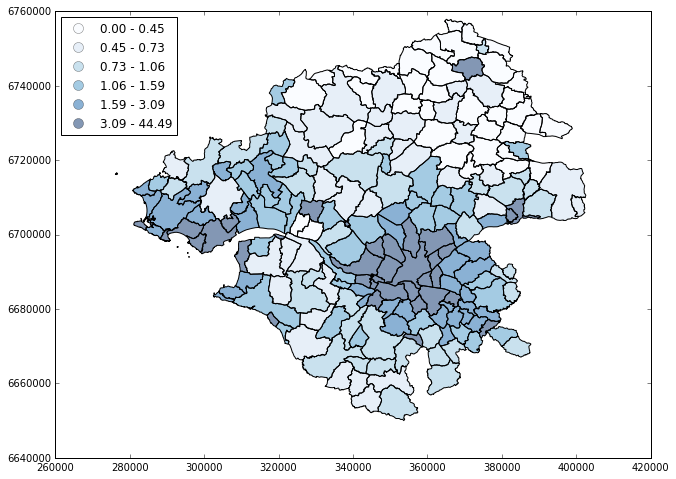

In [13]:
# Communes appartenant à un département avec géométrie polygone ("contour" dans l'API) et retour GeoJSON
params = {
    'fields': ','.join(['nom', 'code', 'surface', 'codeDepartement', 'codeRegion', 'population']),
    'format': 'geojson',
    'geometry': 'contour'
}

req = requests.get('http://geo.api.gouv.fr/departements/44/communes?%s' % urlencode(params))
communes = req.json()

gdf1 = gpd.GeoDataFrame.from_features(communes['features'])
HTML(gdf1.to_html())

# Rendu cartographique simple
gdf1['densite'] = gdf1['population'] /  gdf1['surface']

# Nécessite PYSAL
kw = dict(column='densite', k=6, cmap='Blues')
gdf1.crs = fiona.crs.from_epsg(4326)
gdf1 = gdf1.to_crs({'init': 'epsg:2154'})
ax = gdf1.plot(scheme='QUANTILES', legend=True, **kw)
ax.figure.set_size_inches((15, 8))
ax

In [14]:
# Informations sur une commune depuis son code INSEE
df10 = pd.read_json('https://geo.api.gouv.fr/communes/44109')

# On voit qu'il y a plusieurs lignes du fait des codes postaux
HTML(df10.to_html())

,code,codeDepartement,codeRegion,codesPostaux,nom,population
0,44109,44,52,44000,Nantes,292718
1,44109,44,52,44100,Nantes,292718
2,44109,44,52,44200,Nantes,292718
3,44109,44,52,44300,Nantes,292718


In [15]:
# Recherche de communes par code INSEE
df11 = pd.read_json('https://geo.api.gouv.fr/communes?code=44109')

# Dans ce cas, on a les codes postaux dans une liste pour le champ codePostaux
HTML(df11.to_html())

,code,codeDepartement,codeRegion,codesPostaux,nom,population
0,44109,44,52,"[44000, 44100, 44200, 44300]",Nantes,292718


In [16]:
# Recherche de communes par nom et code de région (pour montrer qu'on peut combiner)
df12 = pd.read_json('https://geo.api.gouv.fr/communes?nom=loire&codeRegion=84')

HTML(df12.to_html())

,_score,code,codeDepartement,codeRegion,codesPostaux,nom,population
0,0.463827,69118,69,84,[69700],Loire-sur-Rhône,2529
1,0.454632,3207,3,84,[03470],Pierrefitte-sur-Loire,508
2,0.423143,43084,43,84,[43370],Cussac-sur-Loire,1728
3,0.421083,42015,42,84,[42670],Belmont-de-la-Loire,1577
4,0.415896,43241,43,84,[43370],Solignac-sur-Loire,1239
5,0.405972,43119,43,84,[43800],Lavoûte-sur-Loire,841
6,0.405972,3177,3,84,[03470],Monétay-sur-Loire,277
7,0.405972,43049,43,84,[43800],Chamalières-sur-Loire,495
8,0.405972,43137,43,84,[43120],Monistrol-sur-Loire,8788
9,0.389784,43012,43,84,[43110],Aurec-sur-Loire,5919


## Swagger

La plupart des exemples ont été créés en inspectant l'API de la GeoAPI via [Swagger](http://swagger.io).

Swagger est une spécification qui permet de spécifier les entrées d'une API c'et à dire quelles URLs, quels paramètres doivent être passés dans un navigateur ou via un appel http via un langage de programmation et quelles réponses doi.
Il existe des surcouches graphiques pour masquer la complexité de la spécification pour que les utilisateurs finaux puissent utiliser l'API en se posant des questions métier (répondre à une question) et pas technique.

Ainsi pour inspecter la GeoAPI, allez sur http://petstore.swagger.io (qui est un visualisateur public) puis coller l'URL suivante https://gist.githubusercontent.com/ThomasG77/021ea577deb5766d2e6cfb824f710eeb/raw/5872182790107b86ac3911b92f0abbe55603fd8b/definition.json et cliquer sur "Explore" (voir capture d'écran ci-dessous).

Ensuite, explorez l'API!

![](images/swagger-instructions-interface-graphique.png)

PS: Le JSON fournit en lien est issu d'une conversion depuis un fichier YAML avec la spécification Swagger du code de l'application de la GeoAPI) du fait que le visualisateur public ne consomme pas du YAML mais du JSON.

## En cours (incomplet)

In [17]:
# Alternative en utilisant Swagger pour créer une API cliente correspondant à l'API
req = requests.get('https://github.com/sgmap/api-communes/raw/master/definition.yml')

content = yaml.load(req.content)

# On enlève les accents dans les titres et les tags car le code generator de swagger
# supprime les lettres avec accents plutôt que les passer en équivalent ascii

# On enlève les accents du titre
content['info']['title'] = unicodedata.normalize('NFD', unicode(content['info']['title'])).encode('ascii', 'ignore')
# On boucle sur les chemins et les méthodes HTTP
for path_key in content['paths'].keys():
    for method in content['paths'][path_key].keys():
        tags = content['paths'][path_key][method]['tags']
        # On ne garde qu'un tag pour ne pas dupliquer dans l'API générée les points d'entrées 
        if len(tags) > 1:
            content['paths'][path_key][method]['tags'] = tags[:1]
        # On enlève les accents
        if len(content['paths'][path_key][method]['tags']) == 1:
            content['paths'][path_key][method]['tags'][0] = unicodedata.normalize('NFD', unicode(content['paths'][path_key][method]['tags'][0])).encode('ascii', 'ignore')

with open('definition.json','wb') as f:
    json.dump(content, f, indent=4)


### Générer un client JavaScript

```
java -jar modules/swagger-codegen-cli/target/swagger-codegen-cli.jar generate -i /home/thomasg/git/geoapi-data-gouv-fr/definition.json -l javascript -o /tmp/geoapi-client/javascript
```

### Générer un client Python
```
java -jar modules/swagger-codegen-cli/target/swagger-codegen-cli.jar generate -i /home/thomasg/git/geoapi-data-gouv-fr/definition.json -l python -o /tmp/geoapi-client/python
```